In [7]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras import backend as K
from keras.models import Model, load_model

In [16]:
def plot_2d_landmarks(img, true, pred):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.imshow(img.reshape((80,120,3)))
    ax.autoscale(False)
    ax.plot(pred[:,0], pred[:,1], '+w')
    plt.plot(true[:,0], true[:,1], '.r')
    ax.axis('off')
    plt.show()


def plot_3d_landmarks(true, pred, gaze_vector):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    Z = true
    ax.plot(np.hstack((Z[0:12,0], Z[0,0])) , np.hstack((Z[0:12,1], Z[0,1])), np.hstack((Z[0:12,2], Z[0,2])), c='r', marker='.')
    ax.plot(np.hstack((Z[12:20,0], Z[12,0])) , np.hstack((Z[12:20,1], Z[12,1])), np.hstack((Z[12:20,2], Z[12,2])), c='b', marker='.')
    ax.plot(np.hstack((Z[20:28,0], Z[20,0])) , np.hstack((Z[20:28,1], Z[20,1])), np.hstack((Z[20:28,2], Z[20,2])), c='g', marker='.')
    
    Z = np.vstack((np.mean(Z[20:28,:], axis=0), np.mean(Z[20:28,:], axis=0) - 0.1 * gaze_vector))
    ax.plot(Z[:,0], Z[:,1], Z[:,2], c='k', marker='^', linewidth=2.0)
    
    Z = pred
    ax.plot(np.hstack((Z[0:12,0], Z[0,0])) , np.hstack((Z[0:12,1], Z[0,1])), np.hstack((Z[0:12,2], Z[0,2])), c='r', marker='s', ls = 'dashed')
    ax.plot(np.hstack((Z[12:20,0], Z[12,0])) , np.hstack((Z[12:20,1], Z[12,1])), np.hstack((Z[12:20,2], Z[12,2])), c='b', marker='s', ls = 'dashed')
    ax.plot(np.hstack((Z[20:28,0], Z[20,0])) , np.hstack((Z[20:28,1], Z[20,1])), np.hstack((Z[20:28,2], Z[20,2])), c='g', marker='s', ls = 'dashed')
    
    ax.axis('off')
    plt.show()


def p_norm_loss(y_true, y_pred):
    return K.mean(K.pow(y_pred - y_true, 4), axis=-1)
    
def p_norm_loss(y_true, y_pred):
    return K.mean(K.pow(y_pred - y_true, 4), axis=-1)

def landmark_accuracy(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred) < 3.)
    
def landmark_accuracy_n(y_true, y_pred, n):
    diff = np.abs(y_true - y_pred)
    points = np.sum(diff, axis=2)
    mask = points < n
    return np.mean(points < n)

def landmark_loss(y_true, y_pred):
    return K.mean( K.square(y_true - y_pred) * K.sigmoid( 5 * (K.abs(y_true - y_pred) - 1) ), axis=-1)

def model_predict(model, test_inputs, num_samples, output_dims):
    pred = model.predict(test_inputs)
    return np.reshape(pred, (num_samples, 28, output_dims))

def load_model_and_predict(filepath, test_inputs, custom_objects, num_samples, output_dims=2):
    model = load_model(filepath, custom_objects)
    pred = model_predict(model, test_inputs, num_samples, output_dims)
    return model, pred

def load_all_models():
    ld3 = []
    ld2 = []
    
    for path in glob.glob('./models/wrong_landmark/*.history'):
        with open(path, 'rb') as f:
#             print(path)
            history = pickle.load(f)
            if len(history['val_loss']) == 70:
                model = load_model(path.replace('.history' , '.h5'), custom_objects)
                if '2D' in path:
                    ld2.append((path, model, history))
                else:
                    ld3.append((path, model, history))
        
    return ld2, ld3
        
def parse_model_desc(full_path):
    desc = re.findall(r'.*\\(.+).history', full_path)
    headpose, topology, dims, objective, losses = desc[0].split('-')
    return {'headpose': headpose,'topology': topology, 'dims': dims,'objective':  objective,'losses': losses}

In [9]:
# Initialization

# Load data
with open('all_data.pkl', 'rb') as f:
    images_train, images_test, ldmks_2d_train, ldmks_2d_test, ldmks_3d_train, ldmks_3d_test, head_pose_train, head_pose_test, look_vec_train, look_vec_test = pickle.load(f)

# Params
num_samples = images_test.shape[0]
    
# Feed-forward params
test_inputs = {'input_img': images_test, 'head_pose': head_pose_test}
custom_objects={'p_norm_loss': p_norm_loss, 'landmark_accuracy' : landmark_accuracy, 'landmark_loss': landmark_loss}

# Reshape for original dimensions for plotting
ldmks_2d_test = np.reshape(ldmks_2d_test, (num_samples, 28, 2))
ldmks_3d_test = np.reshape(ldmks_3d_test, (num_samples, 28, 3))
head_pose_test_raw = np.reshape(head_pose_test, (num_samples, 3,3))

In [39]:
with open('models/HeadTrue-double_tower-2D-mean_absolute_error-[1.1993087813369423, 0.93726084179453129].history', 'rb') as f:
    history_landmark = pickle.load(f)
    
model, preds = load_model_and_predict(
    'models/HeadTrue-double_tower-2D-mean_absolute_error-[1.1993087813369423, 0.93726084179453129].h5', 
    test_inputs, custom_objects, num_samples, output_dims=2)

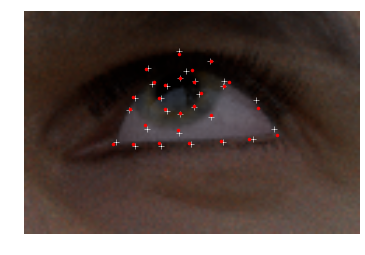

In [41]:
i = np.random.choice(num_samples)
plot_2d_landmarks(images_test[i,:,:,:], ldmks_2d_test[i,:,:], preds[i,:,:])